# How to create a simple pipeline to process a dataset by batches

In [1]:
import sys

from matplotlib import pyplot as plt

# the following line is not required if BatchFlow is installed as a python package.
sys.path.append("../..")
from batchflow import Dataset, Pipeline, R, P, V, C
from batchflow.opensets import MNIST
# from batchflow.utils import plot_images

%matplotlib inline
plt.style.use('grayscale')

In [2]:
BATCH_SIZE = 10

## Create a dataset

[MNIST](http://yann.lecun.com/exdb/mnist/) is a dataset of handwritten digits frequently used as a baseline for machine learning tasks.

Let's download the data and create the dataset (it might take a few minutes to complete)

In [3]:
dataset = MNIST()

MNIST dataset will create instances of [ImagesBatch](https://analysiscenter.github.io/batchflow/intro/images_batch.html).

You can also use [CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html):
```python
from batchflow.opensets import CIFAR10
    
dataset = CIFAR10()
```
It takes much more time to download, though.

For CIFAR examples see [the image augmentation tutorial](./07_image_augmentation_examples.ipynb).

Let's get a batch and look at the dataset content.

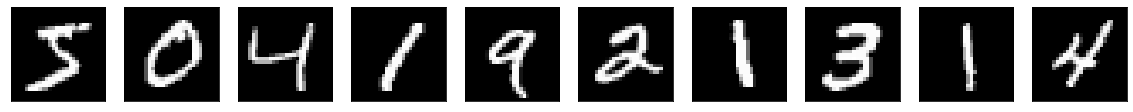

In [5]:
batch = dataset.train.next_batch(BATCH_SIZE)
plot_images(batch.images, ncols=10, figsize=(20,10), subplot_kw={'xticks':[], 'yticks':[]})

Execute the cell above several time to see different batches.

## Define a pipeline

A pipeline represents a sequence of actions applied to a dataset.

These actions might come from [Pipeline API](https://analysiscenter.github.io/batchflow/intro/pipeline.html) or a batch class action-methods (e.g. [ImagesBatch](https://analysiscenter.github.io/batchflow/intro/images_batch.html))

Just write them one after another.

In [6]:
pipeline = (dataset.train.p
            .scale(p=.5, factor=1.5, preserve_shape=True)
            .rotate(p=.5, angle=60)
            .salt(p=.5, color=255, p_noise=.05)
            .elastic_transform(p=.5, alpha=20, sigma=1.8)
)

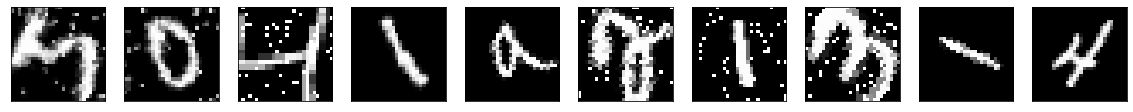

In [7]:
batch = pipeline.next_batch(BATCH_SIZE)
plot_images(batch.images, ncols=10, figsize=(20,10), subplot_kw={'xticks':[], 'yticks':[]})

Read [the documentation](https://analysiscenter.github.io/batchflow/intro/pipeline.html) for advanced pipeline techniques.

## Use pipeline variables

In [8]:
pipeline = (dataset.train.p
            .init_variable('angle', 60)
            .init_variable('factor', 1.5)
            .init_variable('salt_color', 255)
            .init_variable('proba', .5)
            .scale(p=V('proba'), factor=V('factor'), preserve_shape=True)
            .rotate(p=V('proba'), angle=V('angle'))
            .salt(p=V('proba'), color=V('salt_color'), p_noise=.05)
            .elastic_transform(p=V('proba'), alpha=20, sigma=1.8)
)

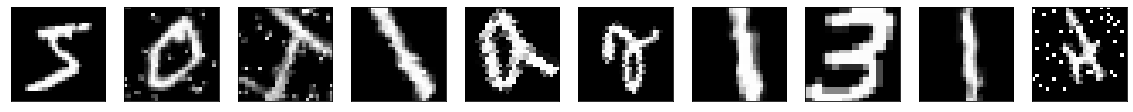

In [9]:
batch = pipeline.next_batch(BATCH_SIZE)
plot_images(batch.images, ncols=10, figsize=(20,10), subplot_kw={'xticks':[], 'yticks':[]})

Read [more about variables and how to use them](https://analysiscenter.github.io/batchflow/intro/pipeline.html#pipeline-variables).

## Pipeline configuration

Same result can be achieved with a pipeline config.

In [10]:
config = dict(angle=60, factor=1.5, salt_color=255, proba=.5)

pipeline = (dataset.train.pipeline(config)
            .scale(p=C('proba'), factor=C('factor'), preserve_shape=True)
            .rotate(p=C('proba'), angle=C('angle'))
            .salt(p=C('proba'), color=C('salt_color'), p_noise=.05)
            .elastic_transform(p=C('proba'), alpha=20, sigma=1.8)
)

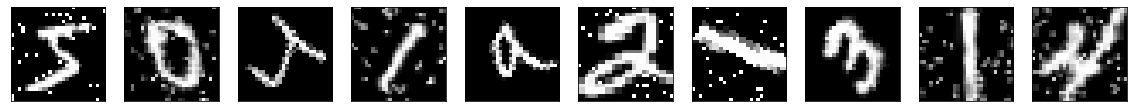

In [11]:
batch = pipeline.next_batch(BATCH_SIZE)
plot_images(batch.images, ncols=10, figsize=(20,10), subplot_kw={'xticks':[], 'yticks':[]})

## Sampling random values

Sometimes you might want random values instead of hard-coded constants.

`R` and `P` [named expressions](https://analysiscenter.github.io/batchflow/intro/named_expr.html) might come in handy here.

In [12]:
config = dict(salt_color=255, proba=.5)

pipeline = (dataset.train.pipeline(config)
            .scale(p=C('proba'), factor=P(R('normal', 1.5, .2)), preserve_shape=True)
            .rotate(p=C('proba'), angle=R('uniform', -45, 45))
            .salt(p=C('proba'), color=C('salt_color'), p_noise=.05)
            .elastic_transform(p=C('proba'), alpha=20, sigma=1.8)
)

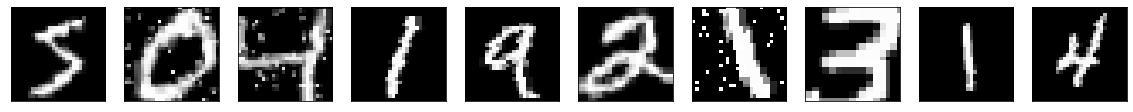

In [13]:
batch = pipeline.next_batch(BATCH_SIZE)
plot_images(batch.images, ncols=10, figsize=(20,10), subplot_kw={'xticks':[], 'yticks':[]})

The difference between `R(...)` and `P(R(...))` is that the former gives a single random value for **all** batch items, while the latter gives a random value for **each** batch item.

## Running pipelines

See [the documentation](https://analysiscenter.github.io/batchflow/intro/pipeline.html#running-pipelines) or [batch operations tutorial](./01_batch_operations.ipynb) for a the detailed description.

## next_batch

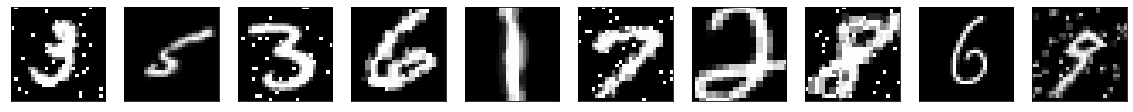

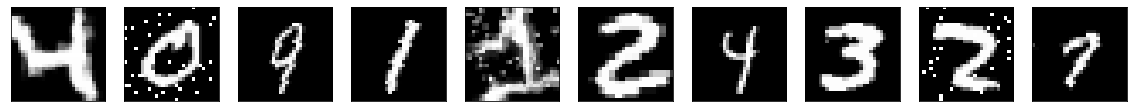

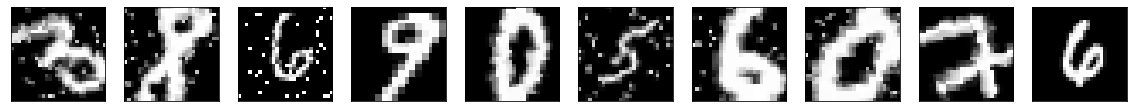

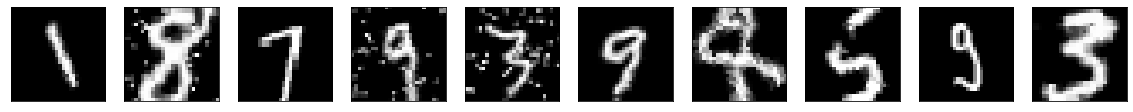

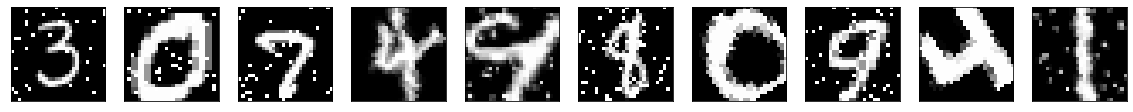

In [14]:
for i in range(5):
    batch = pipeline.next_batch(BATCH_SIZE, n_epochs=1)
    plot_images(batch.images, ncols=10, figsize=(20,10), subplot_kw={'xticks':[], 'yticks':[]})

See [batch operations tutorial](./01_batch_operations.ipynb) for more info about `next_batch` / `gen_batch` and their parameters (`shuffle`, `drop_last`, `n_epochs`, etc)

### gen_batch

While `next_batch` is an ordinary method returning processed batches, `gen_batch` is a generator

In [15]:
for batch in pipeline.gen_batch(BATCH_SIZE, n_epochs=1):
    # do whatever you want with the batch
    pass

Executing this cell might take **a lot of time**, depending on your hardware, pipeline content and the dataset size.

If you want to use large batches with heavy actions (or with I/O operations) then consider using [target](https://analysiscenter.github.io/batchflow/intro/parallel.html?highlight=target#target-threadsIncreasing)='threads'. It might gain considerable boost for multi-CPU platforms.

## run

It is just a concise form of __`for batch in pipeline.gen_batch(...)`__

In [16]:
BATCH_SIZE=100

In [17]:
pipeline.run(BATCH_SIZE, n_epochs=1, shuffle=True, drop_last=True, bar=True, prefetch=2)

100%|██████████| 600/600 [02:00<00:00,  4.64it/s]


There is also a [prefetch](https://analysiscenter.github.io/batchflow/intro/prefetch.html) option for a faster execution and a [bar](https://analysiscenter.github.io/batchflow/intro/pipeline.html#running-pipelines) option to show progress.

## Before and after pipeline

There are things you need to do only once before/after the main pipeline flow. This is where `before` and `after` pipelines come in, providing a convenient way of making one-off actions. For example, you can use `before` pipeline to initialize all the variables and models and `after` to save a models and evaluate metrics.

For example call function in any part of pipeline:

In [18]:
def print_text(text):
    print(text)

You can also add a namespace using `add_namespace` so that the pipeline can see functions from it.
For example define the Utils class which has it's own namespace and call function from it.

In [19]:
class Utils:
    @classmethod
    def print_text_twice(self, text):
        print(text, text)

In [20]:
pipeline = dataset.p.print_text('Main.')

In [21]:
(pipeline.before
 .add_namespace(Utils)
 .print_text('Before.')
 .print_text_twice('Before.'))

In [22]:
pipeline.after.print_text('After.')

In [23]:
pipeline.run(1, n_iters=10)

Before.
Before. Before.
Main.
Main.
Main.
Main.
Main.
Main.
Main.
Main.
Main.
Main.
After.


Functions in `before` and `after` pipelines were called only once. Functions listed in main pipeline were called as many times as many batches passed through pipeline.

Now you might want [to train a model](./03_ready_to_use_model_tf.ipynb) or return to [the table of contents](./00_content.ipynb).